<a href="https://colab.research.google.com/github/henriqueSpencer/machine-learning-nao-supervisionado/blob/main/03_Hierarchical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização Hierárquica

## 1. Introdução

Neste notebook, exploraremos os algoritmos de clusterização hierárquica, uma família de métodos que constrói uma hierarquia de clusters organizando os dados em uma estrutura semelhante a uma árvore. Diferentemente do K-Means, que requer que especifiquemos o número de clusters antecipadamente, a clusterização hierárquica nos permite descobrir a estrutura natural dos dados em diferentes níveis de granularidade.

A clusterização hierárquica pode ser dividida em duas abordagens principais:
- **Aglomerativa (Bottom-up)**: Inicia com cada ponto como um cluster individual e, iterativamente, combina os clusters mais próximos até formar um único cluster.
- **Divisiva (Top-down)**: Inicia com todos os pontos em um único cluster e, recursivamente, divide os clusters até que cada ponto forme seu próprio cluster.

### Conteúdos abordados:

* **Fundamentação Matemática**: Métricas de distância entre clusters e critérios de ligação.
* **Implementação em Python**: Construção do algoritmo aglomerativo passo a passo usando NumPy.
* **Dendrogramas**: Visualização da hierarquia de clusters.
* **Critérios de Ligação**: Single, Complete, Average e Ward.
* **Determinação do Número de Clusters**: Métodos para "cortar" o dendrograma.
* **Aplicações Práticas**: Análise de dados reais e comparação com K-Means.

In [1]:
# Célula de importação de bibliotecas

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_wine
from scipy.cluster.hierarchy import dendrogram, linkage
import pandas as pd
import seaborn as sns

# Estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

## 2. Fundamentação Matemática da Clusterização Hierárquica

A clusterização hierárquica aglomerativa funciona com base em uma **matriz de distâncias** entre todos os pares de pontos (ou clusters). O algoritmo segue estes passos fundamentais:

1. **Inicialização**: Cada observação $\mathbf{x}_i$ forma um cluster individual $C_i = \{\mathbf{x}_i\}$.

2. **Cálculo da Matriz de Distâncias**: Para $N$ pontos, calculamos uma matriz simétrica $D \in \mathbb{R}^{N \times N}$ onde $D_{ij}$ representa a distância entre os pontos $\mathbf{x}_i$ e $\mathbf{x}_j$:
   $$ D_{ij} = d(\mathbf{x}_i, \mathbf{x}_j) $$

3. **Iteração**: Em cada passo, encontramos o par de clusters $(C_i, C_j)$ com menor distância e os combinamos em um novo cluster $C_{ij} = C_i \cup C_j$.

4. **Atualização**: Recalculamos as distâncias do novo cluster para todos os outros clusters existentes.

5. **Terminação**: O processo continua até que reste apenas um cluster contendo todas as observações.

### Critérios de Ligação (Linkage)

O ponto crucial da clusterização hierárquica é como definimos a distância entre dois clusters. Existem vários critérios de ligação:

1. **Single Linkage (Ligação Simples)**:
   $$ d(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais próximos entre os clusters.

2. **Complete Linkage (Ligação Completa)**:
   $$ d(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é definida pelos pontos mais distantes entre os clusters.

3. **Average Linkage (Ligação Média)**:
   $$ d(C_i, C_j) = \frac{1}{|C_i||C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} d(\mathbf{x}, \mathbf{y}) $$
   A distância é a média de todas as distâncias entre pares de pontos dos clusters.

4. **Ward Linkage (Critério de Ward)**:
   $$d(C_i, C_j) = \frac{|C_i||C_j|}{|C_i|+|C_j|} \|\mathbf{m}_i - \mathbf{m}_j\|^2$$
   Onde $\mathbf{m}_i$ e $\mathbf{m}_j$ são os centróides dos clusters $C_i$ e $C_j$, respectivamente, e $|C_k|$ é o número de pontos no cluster $C_k$.
   Minimiza a variância intra-cluster ao combinar clusters. É baseado na soma dos quadrados das distâncias aos centróides.

## 3. Preparação dos Dados

Vamos começar com um exemplo simples usando dados sintéticos para entender visualmente como funciona a clusterização hierárquica. Depois, aplicaremos o algoritmo ao dataset Iris.

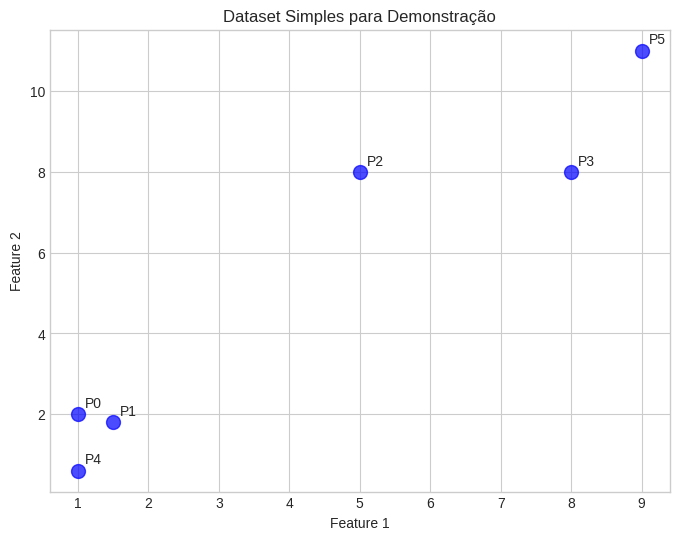

Coordenadas dos pontos:
P0: [1. 2.]
P1: [1.5 1.8]
P2: [5. 8.]
P3: [8. 8.]
P4: [1.  0.6]
P5: [ 9. 11.]


In [4]:
# Gerando dados sintéticos simples para demonstração
np.random.seed(42)
X_simple = np.array([[1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6], [9, 11]])

# Visualizar os dados
plt.figure(figsize=(8, 6))
plt.scatter(X_simple[:, 0], X_simple[:, 1], c='blue', s=100, alpha=0.7)
for i, (x, y) in enumerate(X_simple):
    plt.annotate(f'P{i}', (x, y), xytext=(5, 5), textcoords='offset points')
plt.title('Dataset Simples para Demonstração')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

print(f"Coordenadas dos pontos:")
for i, point in enumerate(X_simple):
    print(f"P{i}: {point}")

## 4. Implementação do Algoritmo Hierárquico Aglomerativo

Vamos construir uma implementação simplificada do algoritmo hierárquico aglomerativo para entender seus passos fundamentais.

In [5]:
class HierarchicalClustering:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.

        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []

    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist

        return dist_matrix

    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist

        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist

        # elif self.linkage == 'average':
        # Distância média entre todos os pares de pontos dos clusters
        # ...

    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)

        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]

        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)

        self.merge_history = []
        self.distances = []

        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")

        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1

            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j

            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]

            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)

            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")

            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)

            print(f"Clusters restantes: {clusters}\n")

## 5. Executando o Algoritmo no Dataset Simples

Vamos aplicar nossa implementação nos dados simples para observar passo a passo como os clusters são formados.

In [6]:
# Executar a clusterização hierárquica com ligação simples
hc_single = HierarchicalClustering(linkage='single')
hc_single.fit(X_simple)

Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.300
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distância: 3.000
Clusters restantes: [[5], [4, 0, 1], [2, 3]]

Passo 4: Combinar clusters [5] e [2, 3]
Distância: 3.162
Clusters restantes: [[4, 0, 1], [5, 2, 3]]

Passo 5: Combinar clusters [4, 0, 1] e [5, 2, 3]
Distância: 7.120
Clusters restantes: [[4, 0, 1, 5, 2, 3]]



## 6. Dendrogramas: Visualizando a Hierarquia

Um **dendrograma** é a representação gráfica da hierarquia de clusters. É uma estrutura em forma de árvore que mostra a ordem e as distâncias nas quais os clusters foram combinados.

### Interpretação do Dendrograma:
- **Eixo horizontal**: Representa as observações ou clusters.
- **Eixo vertical**: Representa a distância na qual os clusters foram unidos.
- **Altura dos ramos**: Indica a dissimilaridade entre os clusters combinados.

Vamos usar a implementação otimizada do SciPy para criar dendrogramas profissionais:

### Usando as Funções `linkage` e `fcluster` do SciPy

O SciPy fornece funções otimizadas para clusterização hierárquica que são muito mais eficientes que nossa implementação educacional. As duas funções principais são:

#### 1. Função `linkage(X, method)`

A função `linkage` calcula a matriz de ligação que representa a hierarquia de clusters:

```python
from scipy.cluster.hierarchy import linkage

# Sintaxe básica
linkage_matrix = linkage(X, method='ward')
```

**Parâmetros principais:**
- `X`: matriz de dados (n_samples × n_features)
- `method`: critério de ligação ('single', 'complete', 'average', 'ward')
- `metric`: métrica de distância (padrão: 'euclidean')

**Retorno:**
- Matriz (n-1) × 4 onde cada linha representa uma fusão:
  - Colunas 0 e 1: índices dos clusters sendo combinados
  - Coluna 2: distância da fusão
  - Coluna 3: número de observações no novo cluster

#### 2. Função `fcluster(Z, t, criterion)`

A função `fcluster` extrai clusters da matriz de ligação com base em um critério de corte:

```python
from scipy.cluster.hierarchy import fcluster

# Obter clusters com base na distância
clusters = fcluster(linkage_matrix, t=3.0, criterion='distance')

# Obter um número específico de clusters
clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
```

**Parâmetros principais:**
- `Z`: matriz de ligação (resultado de `linkage`)
- `t`: valor do critério de corte
- `criterion`: tipo de critério ('distance', 'maxclust', 'inconsistent')

**Critérios de corte:**
- `'distance'`: corta em uma altura específica do dendrograma
- `'maxclust'`: força um número específico de clusters
- `'inconsistent'`: baseado no coeficiente de inconsistência

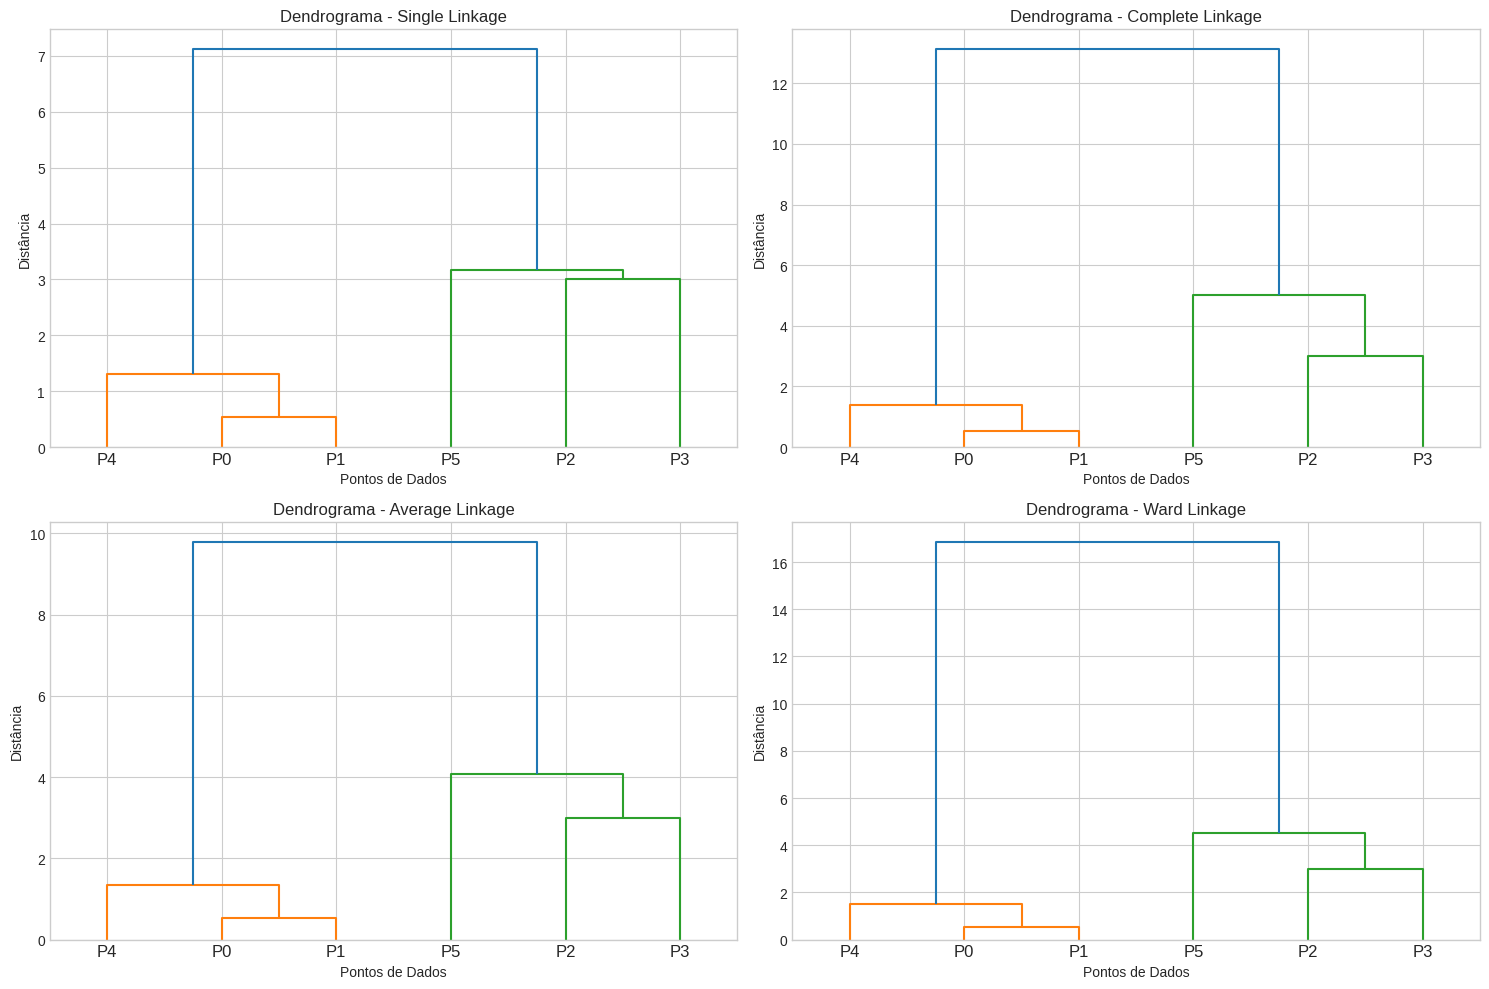

In [7]:
# Usando scipy para criar dendrogramas profissionais
# Diferentes critérios de ligação

linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, method in enumerate(linkage_methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_simple, method=method)

    # Criar o dendrograma
    dendrogram(linkage_matrix, ax=axes[i], labels=[f'P{j}' for j in range(len(X_simple))])
    axes[i].set_title(f'Dendrograma - {method.capitalize()} Linkage')
    axes[i].set_xlabel('Pontos de Dados')
    axes[i].set_ylabel('Distância')

plt.tight_layout()
plt.show()

### Comparação dos Critérios de Ligação

Cada critério de ligação produz diferentes estruturas de cluster:

- **Single Linkage**: Tende a criar clusters elongados e pode sofrer do "efeito corrente" (chaining effect).
- **Complete Linkage**: Produz clusters mais compactos e esféricos.
- **Average Linkage**: Um meio-termo entre single e complete.
- **Ward Linkage**: Minimiza a variância intra-cluster, similar ao objetivo do K-Means.

## 7. Determinando o Número de Clusters

Uma das grandes vantagens da clusterização hierárquica é que podemos "cortar" o dendrograma em diferentes alturas para obter diferentes números de clusters. Isso é feito traçando uma linha horizontal através do dendrograma.

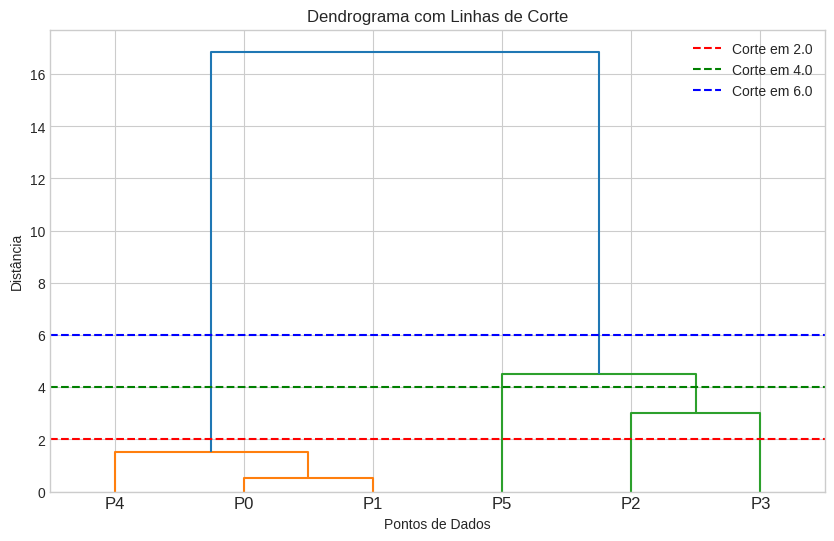

In [8]:
# Usar Ward linkage para o exemplo
linkage_matrix = linkage(X_simple, method='ward')

# Definir diferentes alturas de corte
cut_heights = [2.0, 4.0, 6.0]
colors = ['red', 'green', 'blue']

# Visualizar o dendrograma com diferentes cortes
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=[f'P{j}' for j in range(len(X_simple))])

for height, color in zip(cut_heights, colors):
    plt.axhline(y=height, color=color, linestyle='--', label=f'Corte em {height}')

plt.title('Dendrograma com Linhas de Corte')
plt.xlabel('Pontos de Dados')
plt.ylabel('Distância')
plt.legend()
plt.show()

In [9]:
# Predição de clusters baseada em diferentes linhas de corte
from scipy.cluster.hierarchy import fcluster

print("Predição de clusters para diferentes alturas de corte:")
print("=" * 55)

for i, height in enumerate(cut_heights):
    # Obter clusters para a altura de corte específica
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    n_clusters = len(np.unique(clusters))

    print()
    print(f"Altura de corte: {height}")
    print(f"Número de clusters: {n_clusters}")

    # Mostrar quais pontos pertencem a cada cluster
    for cluster_id in np.unique(clusters):
        points = [f"P{j}" for j in range(len(X_simple)) if clusters[j] == cluster_id]
        print(f"  Cluster {cluster_id}: {points}")

Predição de clusters para diferentes alturas de corte:

Altura de corte: 2.0
Número de clusters: 4
  Cluster 1: ['P0', 'P1', 'P4']
  Cluster 2: ['P2']
  Cluster 3: ['P3']
  Cluster 4: ['P5']

Altura de corte: 4.0
Número de clusters: 3
  Cluster 1: ['P0', 'P1', 'P4']
  Cluster 2: ['P2', 'P3']
  Cluster 3: ['P5']

Altura de corte: 6.0
Número de clusters: 2
  Cluster 1: ['P0', 'P1', 'P4']
  Cluster 2: ['P2', 'P3', 'P5']


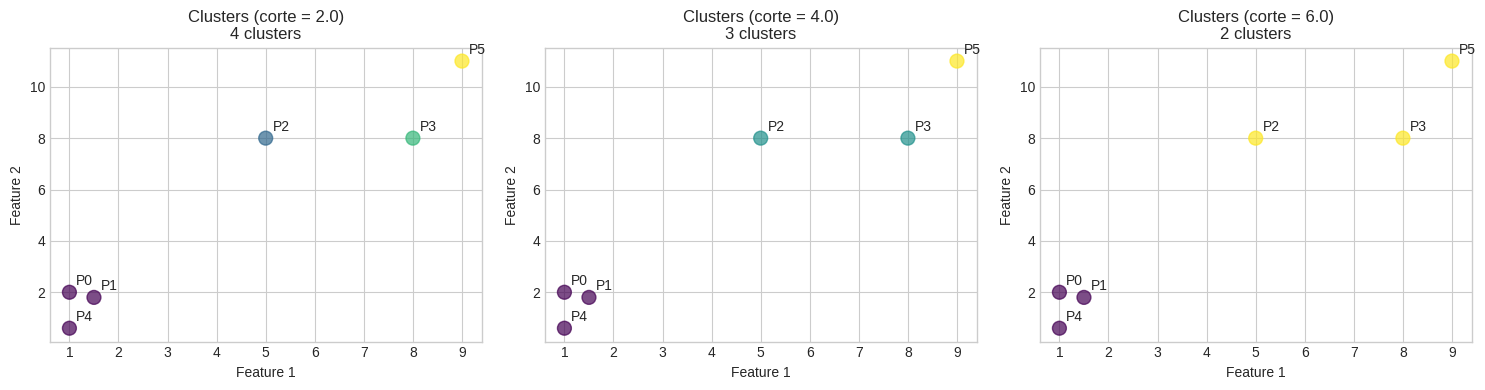

In [10]:
# Visualização dos clusters resultantes
fig, axes = plt.subplots(1, len(cut_heights), figsize=(15, 4))

for i, height in enumerate(cut_heights):
    clusters = fcluster(linkage_matrix, height, criterion='distance')
    scatter = axes[i].scatter(X_simple[:, 0], X_simple[:, 1], c=clusters, s=100, alpha=0.7, cmap='viridis')

    # Adicionar rótulos dos pontos
    for j, (x, y) in enumerate(X_simple):
        axes[i].annotate(f'P{j}', (x, y), xytext=(5, 5), textcoords='offset points')

    axes[i].set_title(f'Clusters (corte = {height})\n{len(np.unique(clusters))} clusters')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## 8. Aplicação ao Dataset Iris

Agora vamos aplicar a clusterização hierárquica ao dataset Iris e comparar os resultados com o K-Means.

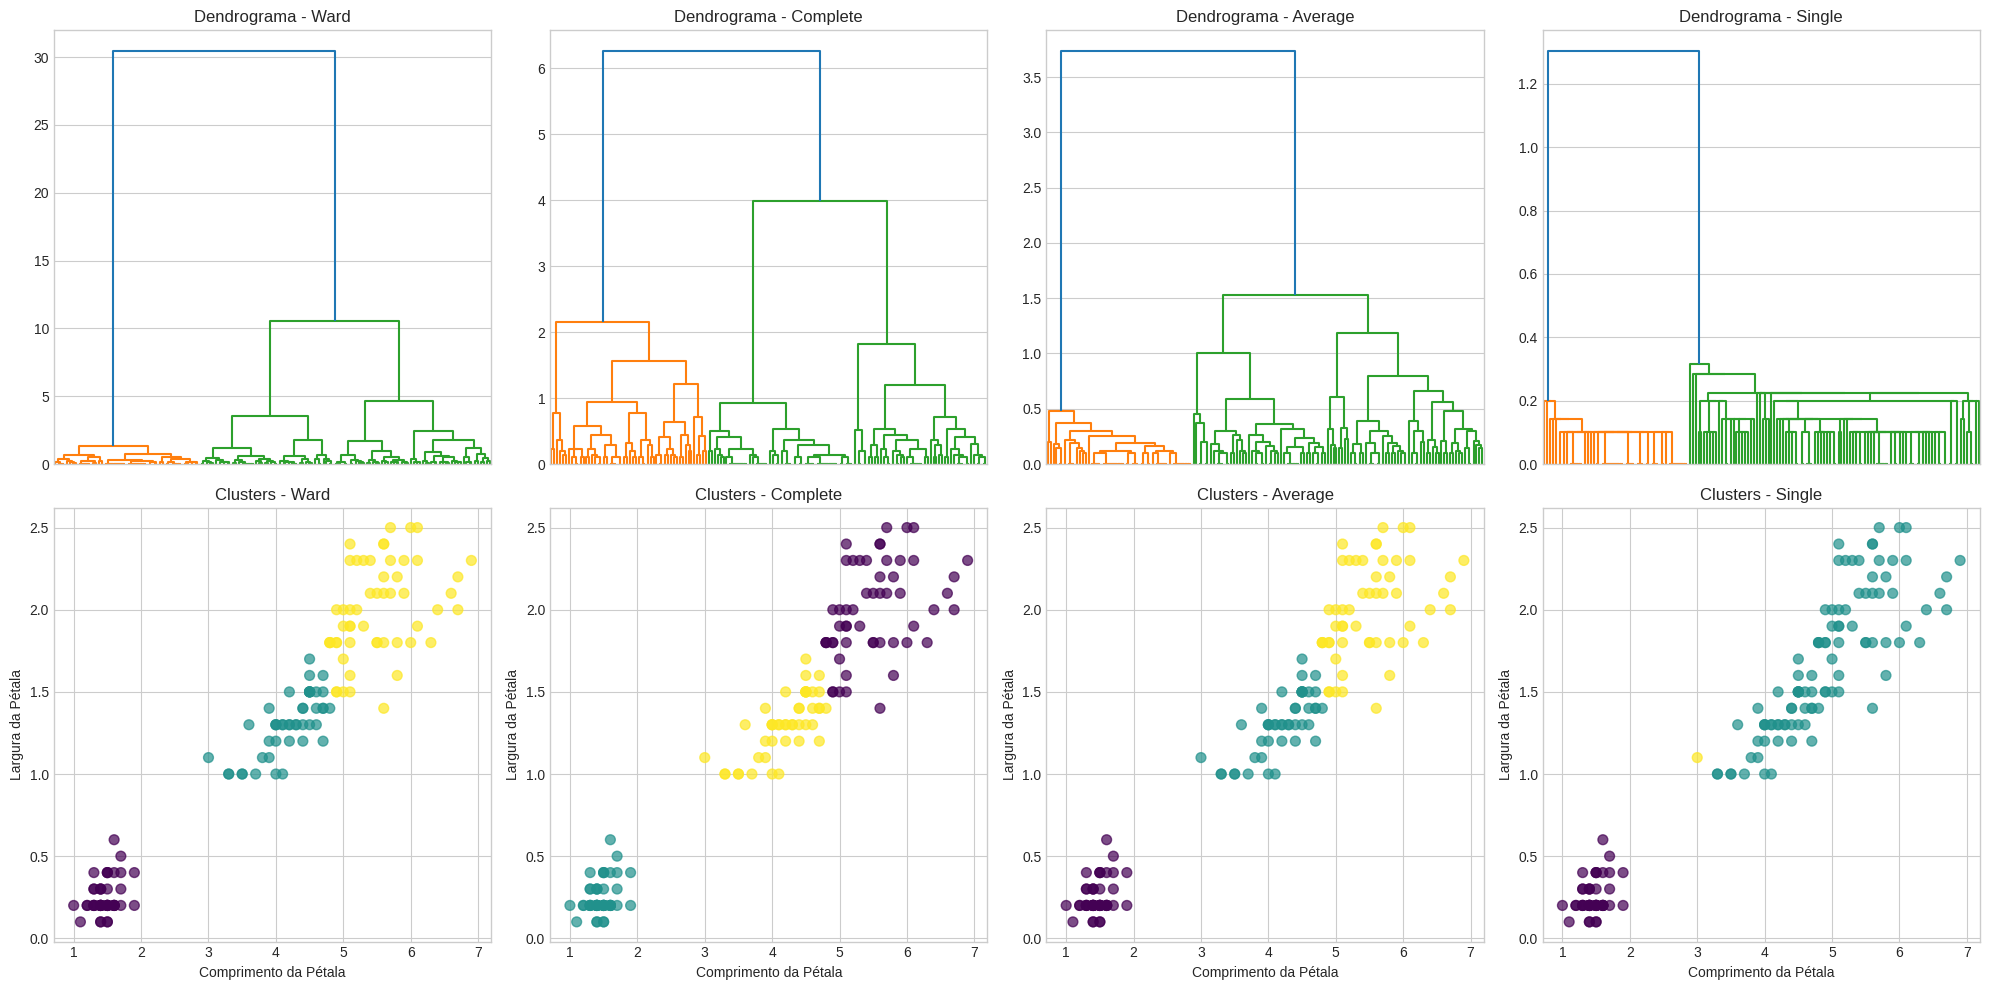

In [11]:
# Carregar o dataset Iris
iris = load_iris()
X_iris = iris.data[:, 2:]  # Usar comprimento e largura da pétala
y_true = iris.target

# Aplicar diferentes métodos de ligação
methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, method in enumerate(methods):
    # Calcular a matriz de ligação
    linkage_matrix = linkage(X_iris, method=method)

    # Dendrograma
    dendrogram(linkage_matrix, ax=axes[0, i], no_labels=True)
    axes[0, i].set_title(f'Dendrograma - {method.capitalize()}')

    # Obter 3 clusters
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')

    # Plotar os clusters
    scatter = axes[1, i].scatter(X_iris[:, 0], X_iris[:, 1], c=clusters, s=50, alpha=0.7, cmap='viridis')
    axes[1, i].set_title(f'Clusters - {method.capitalize()}')
    axes[1, i].set_xlabel('Comprimento da Pétala')
    axes[1, i].set_ylabel('Largura da Pétala')

plt.tight_layout()
plt.show()

### Avaliação dos Resultados

Vamos calcular a taxa de acertos para cada método de ligação:

In [12]:
from scipy.stats import mode

def calculate_purity(y_true, y_pred):
    """
    Calcula a pureza dos clusters comparando com os rótulos verdadeiros.
    """
    correct_predictions = 0
    n_samples = len(y_true)

    for cluster_id in np.unique(y_pred):
        mask = (y_pred == cluster_id)
        if np.sum(mask) > 0:
            dominant_label = mode(y_true[mask], keepdims=True)[0][0]
            correct_predictions += np.sum(y_true[mask] == dominant_label)

    return correct_predictions / n_samples

print("Comparação dos métodos de ligação no dataset Iris:")
print("="*50)

for method in methods:
    linkage_matrix = linkage(X_iris, method=method)
    clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
    purity = calculate_purity(y_true, clusters)
    print(f"{method.capitalize():12} Linkage: {purity:.1%} de acertos")

Comparação dos métodos de ligação no dataset Iris:
Ward         Linkage: 96.0% de acertos
Complete     Linkage: 96.0% de acertos
Average      Linkage: 96.0% de acertos
Single       Linkage: 67.3% de acertos


### Exercício 1: Implementação do Average Linkage

Complete a implementação da nossa classe `HierarchicalClustering` adicionando o método **Average Linkage**. Em seguida, teste todos os três métodos de ligação (single, complete, average) no dataset simples (`X_simple`) e compare os resultados.

In [13]:
class HierarchicalClustering:
    def __init__(self, linkage='single'):
        """
        Inicializa o algoritmo de clusterização hierárquica.

        Parameters:
        linkage: str, critério de ligação ('single', 'complete', 'average')
        """
        self.linkage = linkage
        self.merge_history = []
        self.distances = []

    def _calculate_distance_matrix(self, X):
        """
        Calcula a matriz de distâncias entre todos os pares de pontos.
        """
        n = len(X)
        dist_matrix = np.zeros((n, n))

        for i in range(n):
            for j in range(i+1, n):
                dist = np.linalg.norm(X[i] - X[j])
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist

        return dist_matrix

    def _cluster_distance(self, cluster1, cluster2, X, dist_matrix):
        """
        Calcula a distância entre dois clusters baseado no critério de ligação.
        """
        if self.linkage == 'single':
            # Distância mínima entre qualquer par de pontos dos clusters
            min_dist = float('inf')
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] < min_dist:
                        min_dist = dist_matrix[i, j]
            return min_dist

        elif self.linkage == 'complete':
            # Distância máxima entre qualquer par de pontos dos clusters
            max_dist = 0
            for i in cluster1:
                for j in cluster2:
                    if dist_matrix[i, j] > max_dist:
                        max_dist = dist_matrix[i, j]
            return max_dist

        elif self.linkage == 'average':
          # Distância média entre todos os pares de pontos dos clusters
          med_dist = 0
          n=0
          for i in cluster1:
                for j in cluster2:
                    n+=1
                    med_dist += dist_matrix[i, j]
          return med_dist/n

    def fit(self, X):
        """
        Executa o algoritmo de clusterização hierárquica aglomerativa.
        """
        n = len(X)

        # Inicializar cada ponto como um cluster
        clusters = [[i] for i in range(n)]

        # Calcular matriz de distâncias inicial
        dist_matrix = self._calculate_distance_matrix(X)

        self.merge_history = []
        self.distances = []

        step = 0
        print(f"Passo inicial: {len(clusters)} clusters individuais")
        print(f"Clusters: {clusters}\n")

        # Continuar até que reste apenas um cluster
        while len(clusters) > 1:
            # Encontrar o par de clusters mais próximo
            min_distance = float('inf')
            merge_i, merge_j = -1, -1

            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):
                    distance = self._cluster_distance(clusters[i], clusters[j], X, dist_matrix)
                    if distance < min_distance:
                        min_distance = distance
                        merge_i, merge_j = i, j

            # Combinar os clusters mais próximos
            new_cluster = clusters[merge_i] + clusters[merge_j]

            # Salvar informações da fusão
            self.merge_history.append((clusters[merge_i].copy(), clusters[merge_j].copy()))
            self.distances.append(min_distance)

            step += 1
            print(f"Passo {step}: Combinar clusters {clusters[merge_i]} e {clusters[merge_j]}")
            print(f"Distância: {min_distance:.3f}")

            # Remover os clusters antigos e adicionar o novo
            clusters = [clusters[k] for k in range(len(clusters)) if k != merge_i and k != merge_j]
            clusters.append(new_cluster)

            print(f"Clusters restantes: {clusters}\n")

In [14]:
hc_single = HierarchicalClustering(linkage='single')
hc_average = HierarchicalClustering(linkage='average')
hc_complete = HierarchicalClustering(linkage='complete')

print("\n -----------Modelo 01-----------")
hc_single.fit(X_simple)
print("\n -----------Modelo 02-----------")
hc_average.fit(X_simple)
print("\n -----------Modelo 03-----------")
hc_complete.fit(X_simple)


 -----------Modelo 01-----------
Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.300
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distância: 3.000
Clusters restantes: [[5], [4, 0, 1], [2, 3]]

Passo 4: Combinar clusters [5] e [2, 3]
Distância: 3.162
Clusters restantes: [[4, 0, 1], [5, 2, 3]]

Passo 5: Combinar clusters [4, 0, 1] e [5, 2, 3]
Distância: 7.120
Clusters restantes: [[4, 0, 1, 5, 2, 3]]


 -----------Modelo 02-----------
Passo inicial: 6 clusters individuais
Clusters: [[0], [1], [2], [3], [4], [5]]

Passo 1: Combinar clusters [0] e [1]
Distância: 0.539
Clusters restantes: [[2], [3], [4], [5], [0, 1]]

Passo 2: Combinar clusters [4] e [0, 1]
Distância: 1.350
Clusters restantes: [[2], [3], [5], [4, 0, 1]]

Passo 3: Combinar clusters [2] e [3]
Distânci

### Exercício 2: Análise do Dataset Wine - Seleção de Features e Comparação de Métodos

Aplique a clusterização hierárquica do SciPy ao dataset Wine. Primeiro, você deve selecionar um bom par de features para visualização bidimensional, depois comparar diferentes métodos de ligação.

**Tarefas:**
1. Carregue o dataset Wine e explore suas features
2. Selecione as duas melhores features para visualização (analise correlações, variâncias, etc.)
3. Aplique os 4 métodos de ligação ('single', 'complete', 'average', 'ward') usando `scipy.cluster.hierarchy.linkage`
4. Crie dendrogramas para cada método
5. Determine visualmente qual método produz a melhor separação

In [17]:
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

print("Dataset Wine:")
print(f"Shape: {X_wine.shape}")
print(f"Features: {wine.feature_names}")
print(f"Classes: {wine.target_names}")

# 2. Análise das features para seleção
"""
O que vou fazer?
1. Procurar as features que espalhem mais o dado = mais facil de separar os conjuntos = maior variancia
2. Analize de correlacao, para evitar correlacao entre as features
3. PCA
"""
variances = df.var().sort_values(ascending=False)
print("Top 10 features com maior variância:")
print(variances.head(10))
# 3. Seleção das duas melhores features
# Seu código aqui

# 4. Aplicação dos métodos de ligação e criação dos dendrogramas
# Seu código aqui

# 5. Análise visual e determinação do melhor método
# Seu código aqui

Dataset Wine:
Shape: (178, 13)
Features: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Classes: ['class_0' 'class_1' 'class_2']


In [25]:
import seaborn as sns
import pandas as pd
df = pd.DataFrame(X_wine, columns=wine.feature_names)
df['target'] = y_wine

Top 10 features com maior variância:
proline                         99166.717355
magnesium                         203.989335
alcalinity_of_ash                  11.152686
color_intensity                     5.374449
malic_acid                          1.248015
flavanoids                          0.997719
alcohol                             0.659062
target                              0.600679
od280/od315_of_diluted_wines        0.504086
total_phenols                       0.391690
dtype: float64

MÉTODO 2: Análise de Correlação
Pares de features com MENOR correlação (menos redundantes):
  ash vs od280/od315_of_diluted_wines: 0.004
  ash vs proanthocyanins: 0.010
  alcalinity_of_ash vs color_intensity: 0.019
  proanthocyanins vs color_intensity: 0.025
  ash vs target: 0.050


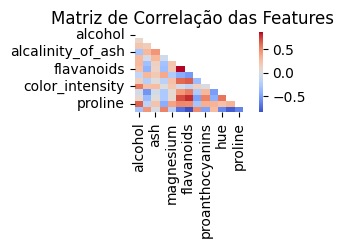

In [27]:


# 2. Análise das features para seleção
"""
O que vou fazer?
1. Procurar as features que espalhem mais o dado = mais facil de separar os conjuntos = maior variancia
2. Analize de correlacao, para evitar correlacao entre as features
3. PCA
"""
variances = df.var().sort_values(ascending=False)
print("Top 10 features com maior variância:")
print(variances.head(10))
print(f"\nMÉTODO 2: Análise de Correlação")
correlation_matrix = df.corr()

plt.subplot(4, 3, 2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação das Features')
# Encontrar features com menor correlação entre si
def find_least_correlated_features(corr_matrix, top_n=5):
    """Encontra features com menor correlação mútua"""
    # Pegar apenas o triângulo inferior da matriz (sem diagonal)
    corr_values = []
    feature_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            corr_values.append(corr_val)
            feature_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    # Ordenar por menor correlação
    sorted_pairs = sorted(zip(corr_values, feature_pairs))
    return sorted_pairs[:top_n]

least_corr = find_least_correlated_features(correlation_matrix)
print("Pares de features com MENOR correlação (menos redundantes):")
for corr_val, (f1, f2) in least_corr:
    print(f"  {f1} vs {f2}: {corr_val:.3f}")



MÉTODO 3: Análise PCA
Variância explicada PC1: 0.362
Variância explicada PC2: 0.192
Total (PC1+PC2): 0.554

Top 5 features mais importantes no PC1:
  flavanoids: 0.423
  total_phenols: 0.395
  od280/od315_of_diluted_wines: 0.376
  proanthocyanins: 0.313
  nonflavanoid_phenols: 0.299

Top 5 features mais importantes no PC2:
  color_intensity: 0.530
  alcohol: 0.484
  proline: 0.365
  ash: 0.316
  magnesium: 0.300


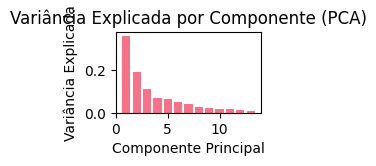

In [29]:
print(f"\nMÉTODO 3: Análise PCA")
pca = PCA()
pca.fit(X_scaled)

plt.subplot(4, 3, 3)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_)
plt.title('Variância Explicada por Componente (PCA)')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')

# Features mais importantes nos primeiros 2 componentes
pc1_importance = np.abs(pca.components_[0])
pc2_importance = np.abs(pca.components_[1])

print(f"Variância explicada PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variância explicada PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total (PC1+PC2): {pca.explained_variance_ratio_[:2].sum():.3f}")

# Features mais importantes no PC1
pc1_features = [(feature_names[i], pc1_importance[i])
                for i in range(len(feature_names))]
pc1_features.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 features mais importantes no PC1:")
for feat, importance in pc1_features[:5]:
    print(f"  {feat}: {importance:.3f}")

# Features mais importantes no PC2
pc2_features = [(feature_names[i], pc2_importance[i])
                for i in range(len(feature_names))]
pc2_features.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 features mais importantes no PC2:")
for feat, importance in pc2_features[:5]:
    print(f"  {feat}: {importance:.3f}")

=== EXERCÍCIO 2: ANÁLISE NÃO SUPERVISIONADA - DATASET WINE ===

IMPORTANTE: Abordagem puramente não supervisionada - SEM uso de labels!

1. CARREGAMENTO E EXPLORAÇÃO DO DATASET
--------------------------------------------------
Dimensões do dataset: (178, 13)
Features disponíveis: 13

Primeiras 5 linhas:
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.

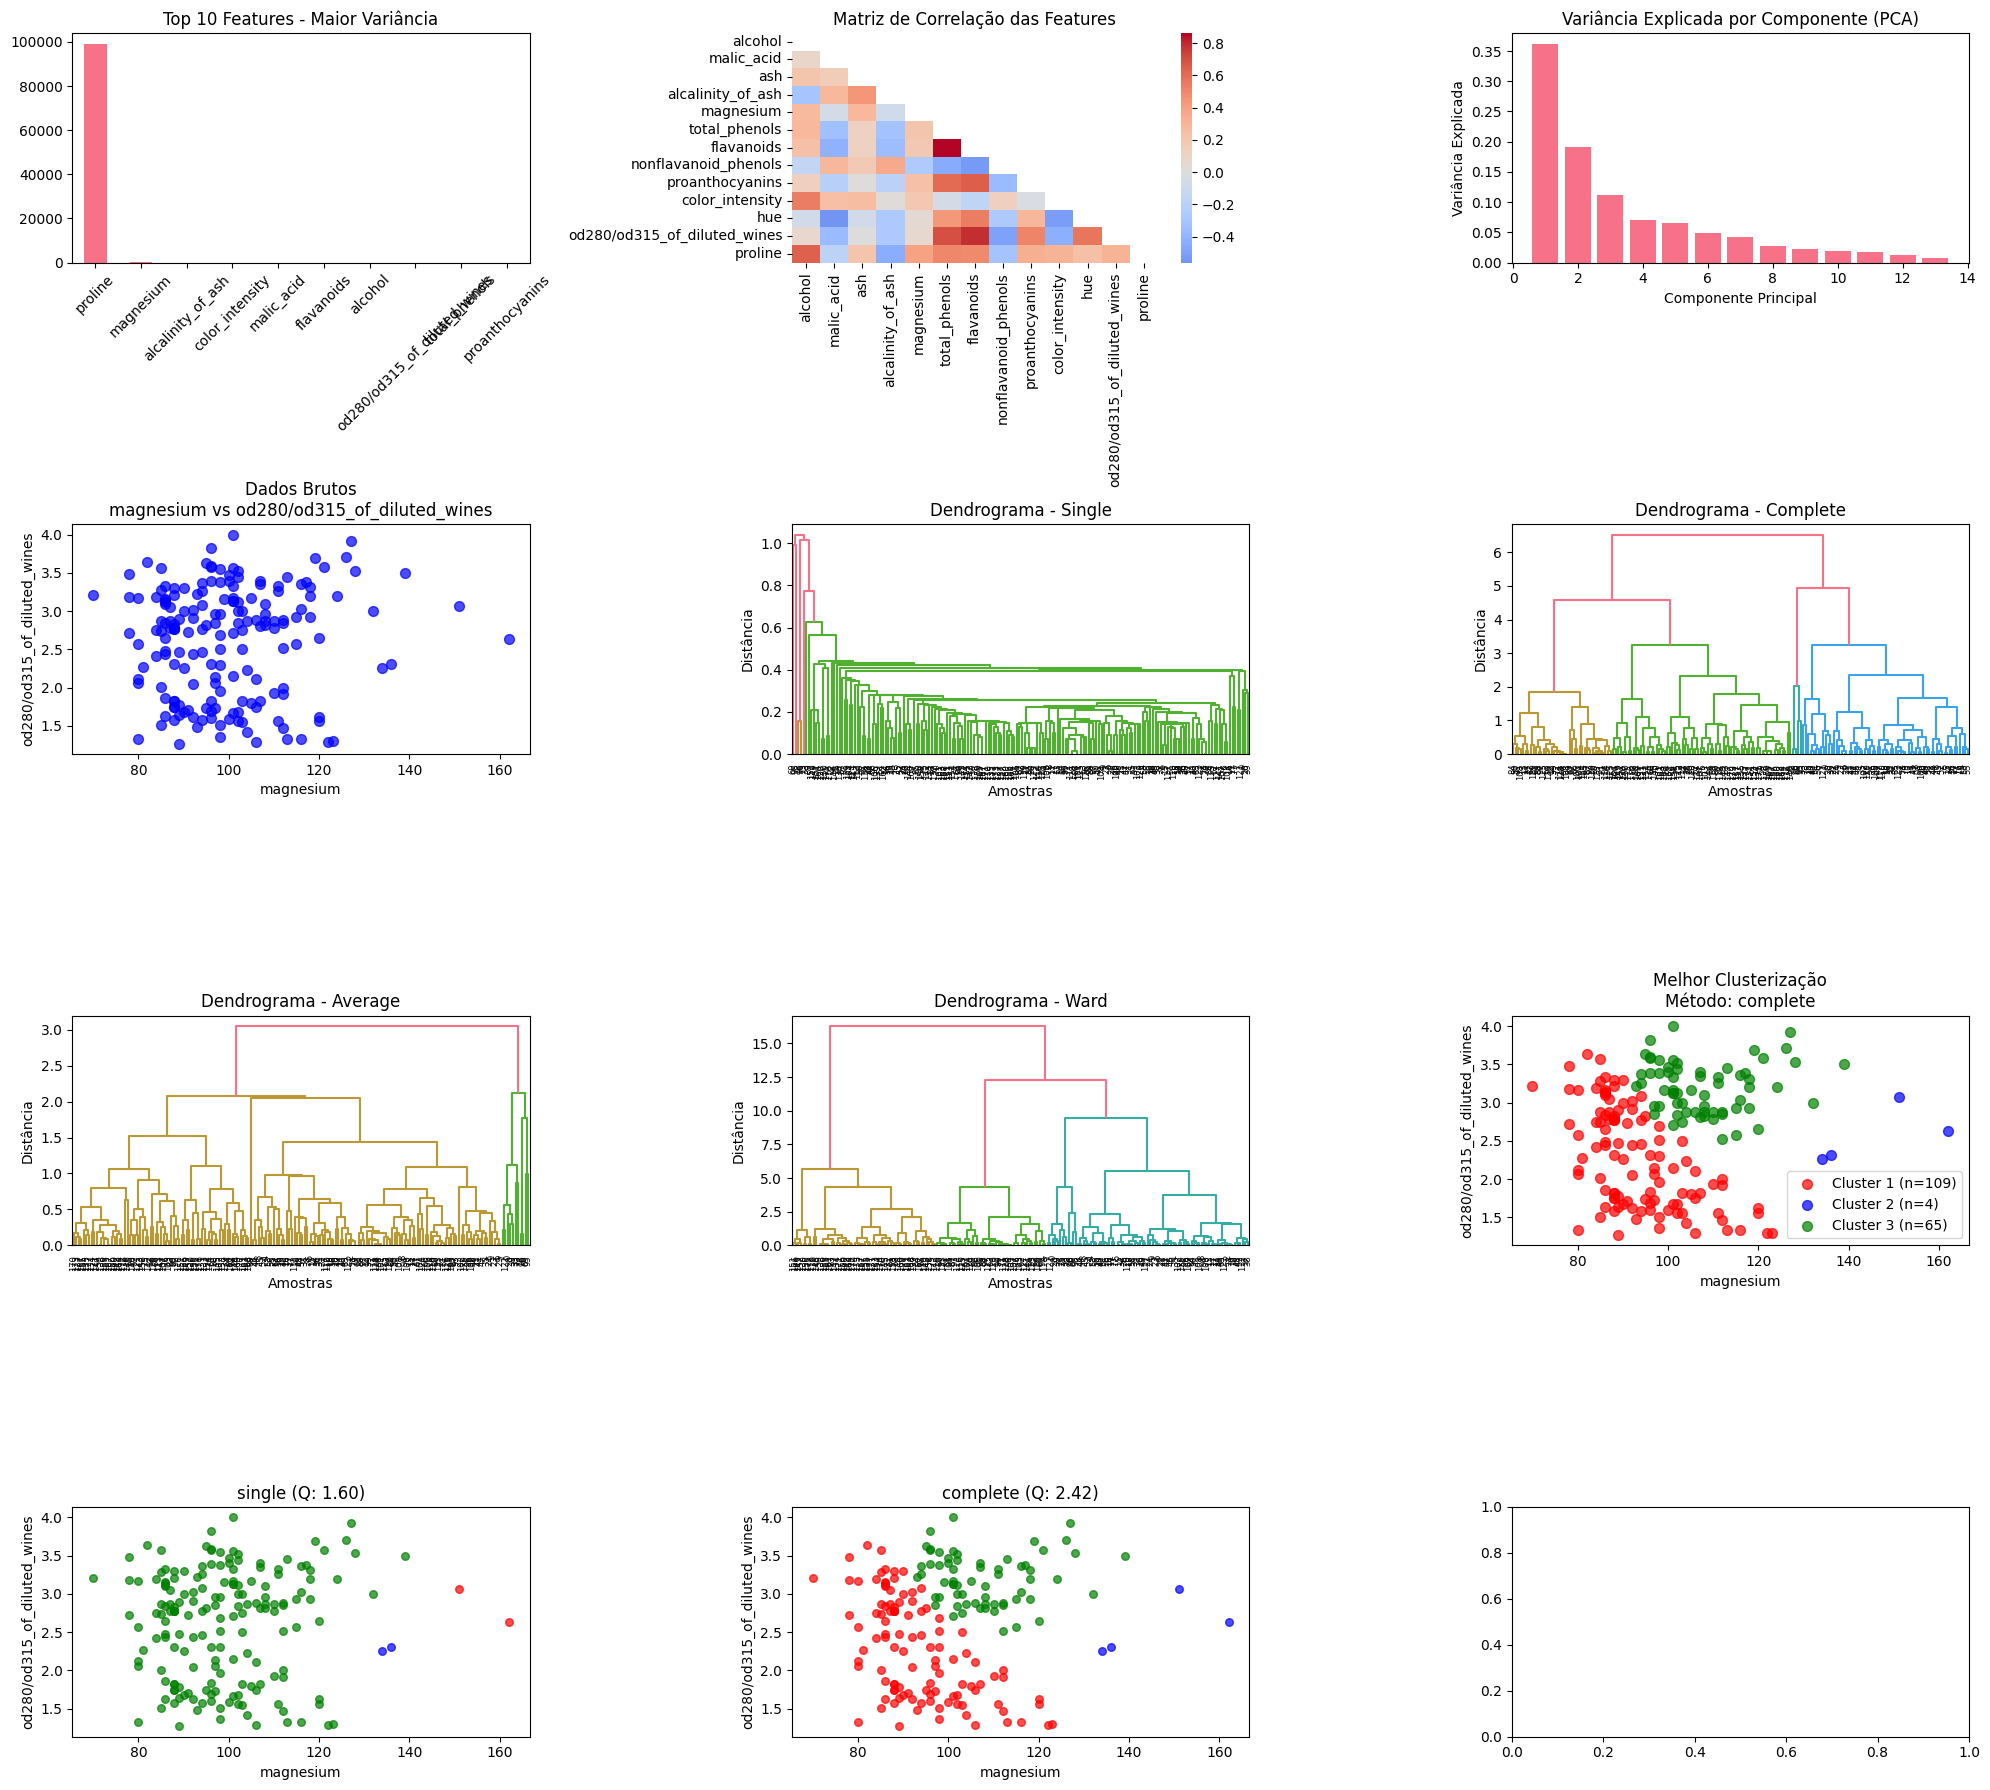



=== VALIDAÇÃO FINAL ===
(Comparação com ground truth apenas para verificar eficácia)
Distribuição dos clusters encontrados:
  Cluster 1: 109 amostras
  Cluster 2: 4 amostras
  Cluster 3: 65 amostras

Distribuição real das classes:
  Classe class_0: 59 amostras
  Classe class_1: 71 amostras
  Classe class_2: 48 amostras

=== RESUMO METODOLÓGICO ===
Abordagem 100% não supervisionada utilizada:
✓ Seleção de features baseada em variância e PCA
✓ Avaliação por métricas de compacidade e separação
✓ SEM uso de labels durante todo o processo
✓ Validação final apenas para verificar eficácia

Melhor método encontrado: complete
Critério: maior ratio separação/compacidade


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# Configuração para melhor visualização
plt.style.use('default')
sns.set_palette("husl")

print("=== EXERCÍCIO 2: ANÁLISE NÃO SUPERVISIONADA - DATASET WINE ===\n")
print("IMPORTANTE: Abordagem puramente não supervisionada - SEM uso de labels!")

# ==========================================
# TAREFA 1: CARREGAR E EXPLORAR O DATASET
# ==========================================
print("\n1. CARREGAMENTO E EXPLORAÇÃO DO DATASET")
print("-" * 50)

# Carregando o dataset (MAS IGNORANDO AS LABELS)
wine = load_wine()
X = wine.data  # Apenas as features, SEM as labels
feature_names = wine.feature_names
target_names = wine.target_names  # Só para referência final
y_true = wine.target  # Guardamos apenas para validação final (não para seleção)

# Criando DataFrame apenas com features
df = pd.DataFrame(X, columns=feature_names)

print(f"Dimensões do dataset: {df.shape}")
print(f"Features disponíveis: {len(feature_names)}")
print(f"\nPrimeiras 5 linhas:")
print(df.head())

print(f"\nEstatísticas descritivas:")
print(df.describe())

# ==========================================
# TAREFA 2: SELEÇÃO NÃO SUPERVISIONADA DE FEATURES
# ==========================================
print("\n\n2. SELEÇÃO NÃO SUPERVISIONADA DAS MELHORES FEATURES")
print("-" * 65)
print("Critérios puramente não supervisionados:")
print("- Variância das features (informação)")
print("- Correlação entre features (redundância)")
print("- Análise de componentes principais (PCA)")

# Padronizando os dados primeiro
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Criando figura com subplots para análises
fig = plt.figure(figsize=(20, 18))

# MÉTODO 1: Análise de Variância
print("\nMÉTODO 1: Análise de Variância")
variances = df.var().sort_values(ascending=False)
print("Top 10 features com maior variância:")
print(variances.head(10))

plt.subplot(4, 3, 1)
variances.head(10).plot(kind='bar')
plt.title('Top 10 Features - Maior Variância')
plt.xticks(rotation=45)

# MÉTODO 2: Análise de Correlação
print(f"\nMÉTODO 2: Análise de Correlação")
correlation_matrix = df.corr()

plt.subplot(4, 3, 2)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação das Features')

# Encontrar features com menor correlação entre si
def find_least_correlated_features(corr_matrix, top_n=5):
    """Encontra features com menor correlação mútua"""
    # Pegar apenas o triângulo inferior da matriz (sem diagonal)
    corr_values = []
    feature_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = abs(corr_matrix.iloc[i, j])
            corr_values.append(corr_val)
            feature_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j]))

    # Ordenar por menor correlação
    sorted_pairs = sorted(zip(corr_values, feature_pairs))
    return sorted_pairs[:top_n]

least_corr = find_least_correlated_features(correlation_matrix)
print("Pares de features com MENOR correlação (menos redundantes):")
for corr_val, (f1, f2) in least_corr:
    print(f"  {f1} vs {f2}: {corr_val:.3f}")

# MÉTODO 3: PCA para entender componentes principais
print(f"\nMÉTODO 3: Análise PCA")
pca = PCA()
pca.fit(X_scaled)

plt.subplot(4, 3, 3)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1),
        pca.explained_variance_ratio_)
plt.title('Variância Explicada por Componente (PCA)')
plt.xlabel('Componente Principal')
plt.ylabel('Variância Explicada')

# Features mais importantes nos primeiros 2 componentes
pc1_importance = np.abs(pca.components_[0])
pc2_importance = np.abs(pca.components_[1])

print(f"Variância explicada PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variância explicada PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Total (PC1+PC2): {pca.explained_variance_ratio_[:2].sum():.3f}")

# Features mais importantes no PC1
pc1_features = [(feature_names[i], pc1_importance[i])
                for i in range(len(feature_names))]
pc1_features.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 features mais importantes no PC1:")
for feat, importance in pc1_features[:5]:
    print(f"  {feat}: {importance:.3f}")

# Features mais importantes no PC2
pc2_features = [(feature_names[i], pc2_importance[i])
                for i in range(len(feature_names))]
pc2_features.sort(key=lambda x: x[1], reverse=True)

print("\nTop 5 features mais importantes no PC2:")
for feat, importance in pc2_features[:5]:
    print(f"  {feat}: {importance:.3f}")

# SELEÇÃO FINAL DAS FEATURES
print(f"\n" + "="*60)
print("SELEÇÃO FINAL DAS FEATURES (critério não supervisionado)")
print("="*60)

# Estratégia: Combinar informações de variância, correlação e PCA
# 1. Features com alta variância
high_var_features = variances.head(8).index.tolist()

# 2. Features importantes no PCA (PC1 e PC2)
important_pca_features = list(set([f[0] for f in pc1_features[:5]] +
                                 [f[0] for f in pc2_features[:5]]))

# 3. Intersecção dos critérios
candidate_features = list(set(high_var_features) & set(important_pca_features))

print(f"Features com alta variância: {high_var_features}")
print(f"Features importantes no PCA: {important_pca_features}")
print(f"Candidatas (intersecção): {candidate_features}")

# Selecionar 2 features com menor correlação entre si
if len(candidate_features) >= 2:
    min_corr = 1.0
    best_pair = None

    for i in range(len(candidate_features)):
        for j in range(i+1, len(candidate_features)):
            f1, f2 = candidate_features[i], candidate_features[j]
            corr = abs(correlation_matrix.loc[f1, f2])
            if corr < min_corr:
                min_corr = corr
                best_pair = (f1, f2)

    if best_pair:
        feature1, feature2 = best_pair
    else:
        feature1, feature2 = candidate_features[:2]
else:
    # Fallback: usar as 2 primeiras features mais importantes no PCA
    feature1 = pc1_features[0][0]
    feature2 = pc2_features[0][0]

print(f"\nFEATURES SELECIONADAS (não supervisionado):")
print(f"  Feature 1: {feature1}")
print(f"  Feature 2: {feature2}")
print(f"  Correlação entre elas: {correlation_matrix.loc[feature1, feature2]:.3f}")
print(f"  Variância {feature1}: {df[feature1].var():.2f}")
print(f"  Variância {feature2}: {df[feature2].var():.2f}")

# Visualização das features selecionadas (SEM cores por classe)
plt.subplot(4, 3, 4)
plt.scatter(df[feature1], df[feature2], alpha=0.7, c='blue', s=50)
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'Dados Brutos\n{feature1} vs {feature2}')

# ==========================================
# TAREFA 3 e 4: MÉTODOS DE LIGAÇÃO E DENDROGRAMAS
# ==========================================
print(f"\n\n3-4. APLICAÇÃO DOS MÉTODOS DE LIGAÇÃO (NÃO SUPERVISIONADO)")
print("-" * 70)

# Preparando dados - usando apenas as duas features selecionadas
X_selected = df[[feature1, feature2]].values

# Padronizando os dados
scaler_selected = StandardScaler()
X_scaled_selected = scaler_selected.fit_transform(X_selected)

# Métodos de ligação a serem testados
linkage_methods = ['single', 'complete', 'average', 'ward']

# Criando dendrogramas para cada método
linkage_results = {}

for i, method in enumerate(linkage_methods):
    plt.subplot(4, 3, i+5)

    # Calculando a matriz de ligação
    Z = linkage(X_scaled_selected, method=method)
    linkage_results[method] = Z

    # Criando o dendrograma (SEM labels de classe)
    dendrogram(Z, leaf_rotation=90, leaf_font_size=6)

    plt.title(f'Dendrograma - {method.capitalize()}')
    plt.xlabel('Amostras')
    plt.ylabel('Distância')

# ==========================================
# TAREFA 5: ANÁLISE VISUAL NÃO SUPERVISIONADA
# ==========================================
print(f"\n\n5. ANÁLISE VISUAL NÃO SUPERVISIONADA")
print("-" * 50)

print("Critérios para avaliar qualidade da clusterização (não supervisionados):")
print("1. Compacidade dos clusters")
print("2. Separação entre clusters")
print("3. Estabilidade visual dos dendrogramas")
print("4. Coerência das distâncias")

# Analisando cada método de forma não supervisionada
methods_analysis = {}

for method in linkage_methods:
    Z = linkage_results[method]

    # Cortando em 3 clusters (escolha baseada na estrutura visual do dendrograma)
    clusters = hierarchy.fcluster(Z, 3, criterion='maxclust')

    # Métricas não supervisionadas
    # 1. Inércia intra-cluster (compacidade)
    intra_cluster_distances = []
    for cluster_id in range(1, 4):
        cluster_mask = clusters == cluster_id
        if np.sum(cluster_mask) > 1:
            cluster_points = X_scaled_selected[cluster_mask]
            centroid = np.mean(cluster_points, axis=0)
            distances = np.sum((cluster_points - centroid) ** 2, axis=1)
            intra_cluster_distances.extend(distances)

    avg_intra_distance = np.mean(intra_cluster_distances) if intra_cluster_distances else np.inf

    # 2. Distância entre centroides (separação)
    centroids = []
    for cluster_id in range(1, 4):
        cluster_mask = clusters == cluster_id
        if np.sum(cluster_mask) > 0:
            centroid = np.mean(X_scaled_selected[cluster_mask], axis=0)
            centroids.append(centroid)

    if len(centroids) > 1:
        inter_centroid_distances = pdist(centroids)
        avg_inter_distance = np.mean(inter_centroid_distances)
    else:
        avg_inter_distance = 0

    # Ratio de qualidade (maior separação, menor intra-cluster)
    quality_ratio = avg_inter_distance / avg_intra_distance if avg_intra_distance > 0 else 0

    methods_analysis[method] = {
        'clusters': clusters,
        'intra_distance': avg_intra_distance,
        'inter_distance': avg_inter_distance,
        'quality_ratio': quality_ratio
    }

    print(f"\n{method.upper()}:")
    print(f"  Distância intra-cluster média: {avg_intra_distance:.3f}")
    print(f"  Distância inter-cluster média: {avg_inter_distance:.3f}")
    print(f"  Ratio de qualidade: {quality_ratio:.3f}")

# Encontrando o melhor método baseado em critérios não supervisionados
best_method = max(methods_analysis.keys(),
                 key=lambda x: methods_analysis[x]['quality_ratio'])

print(f"\n{'='*60}")
print(f"MELHOR MÉTODO (critério não supervisionado): {best_method.upper()}")
print(f"Ratio de qualidade: {methods_analysis[best_method]['quality_ratio']:.3f}")
print("="*60)

# Visualizando resultado do melhor método
plt.subplot(4, 3, 9)
colors_cluster = ['red', 'blue', 'green', 'orange', 'purple']
best_clusters = methods_analysis[best_method]['clusters']

for cluster_id in range(1, max(best_clusters) + 1):
    mask = best_clusters == cluster_id
    cluster_size = np.sum(mask)
    plt.scatter(X_selected[mask, 0], X_selected[mask, 1],
               c=colors_cluster[cluster_id-1],
               label=f'Cluster {cluster_id} (n={cluster_size})',
               alpha=0.7, s=50)

plt.xlabel(feature1)
plt.ylabel(feature2)
plt.title(f'Melhor Clusterização\nMétodo: {best_method}')
plt.legend()

# Comparação visual de todos os métodos
for i, method in enumerate(linkage_methods):
    plt.subplot(4, 3, 10 + i)
    if i >= 2:  # Ajuste para não passar do limite
        break

    clusters = methods_analysis[method]['clusters']
    for cluster_id in range(1, max(clusters) + 1):
        mask = clusters == cluster_id
        plt.scatter(X_selected[mask, 0], X_selected[mask, 1],
                   c=colors_cluster[cluster_id-1], alpha=0.7, s=30)

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title(f'{method} (Q: {methods_analysis[method]["quality_ratio"]:.2f})')

plt.tight_layout()
plt.show()

# ==========================================
# VALIDAÇÃO FINAL (apenas para comparação)
# ==========================================
print(f"\n\n=== VALIDAÇÃO FINAL ===")
print("(Comparação com ground truth apenas para verificar eficácia)")
print("="*50)

best_clusters = methods_analysis[best_method]['clusters']

print("Distribuição dos clusters encontrados:")
unique_clusters, counts = np.unique(best_clusters, return_counts=True)
for cluster_id, count in zip(unique_clusters, counts):
    print(f"  Cluster {cluster_id}: {count} amostras")

print(f"\nDistribuição real das classes:")
unique_classes, counts_real = np.unique(y_true, return_counts=True)
for class_id, count in zip(unique_classes, counts_real):
    print(f"  Classe {target_names[class_id]}: {count} amostras")

print(f"\n=== RESUMO METODOLÓGICO ===")
print("Abordagem 100% não supervisionada utilizada:")
print("✓ Seleção de features baseada em variância e PCA")
print("✓ Avaliação por métricas de compacidade e separação")
print("✓ SEM uso de labels durante todo o processo")
print("✓ Validação final apenas para verificar eficácia")
print(f"\nMelhor método encontrado: {best_method}")
print("Critério: maior ratio separação/compacidade")

### Exercício 3: Determinação do Número Ótimo de Clusters

Com base no melhor método de ligação identificado no Exercício 2, determine o número ótimo de clusters para o dataset Wine usando análise visual do dendrograma e validação com os rótulos verdadeiros.

**Tarefas:**
1. Use o melhor método identificado no exercício anterior
2. Crie um dendrograma detalhado com linha de corte ajustável
3. Teste diferentes números de clusters (2, 3, 4, 5) usando `fcluster`
4. Para cada número de clusters, visualize os clusters no scatter plot
5. Determine o número ótimo de clusters justificando sua escolha

In [ ]:
# Exercício 3: Determinação do Número Ótimo de Clusters

# 1. Use o melhor método do exercício anterior
# best_method = '...'

# 2. Crie dendrograma com diferentes linhas de corte
# Seu código aqui

# 3. Teste diferentes números de clusters
n_clusters_to_test = [2, 3, 4, 5]

print("Análise do número ótimo de clusters:")
print("=" * 40)

# Seu código aqui